# 线性回归的简洁实现

## 生成数据集

In [195]:
import numpy as np
import random
import torch
# data是数据加载工具集。
from torch.utils import data
from d2l import torch as d2l

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## 读取数据集
is_train从字面理解就是是否在训练（布尔值）。为真会在每个迭代周期打乱数据，反之不会。
训练集通常要打乱，验证集/测试集一般不打乱。

In [196]:
# 函数目的就是把张量数据打包成Pytorch的Dataloader，方便后续按批次迭代训练或评估。
# 几乎是一个标准用法
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

iter的作用就是把一个可迭代的对象转化成一个迭代器。
迭代器在整体代码中的作用就是，帮助提取batch来进行训练。

In [197]:
next(iter(data_iter))

[tensor([[-1.0838, -0.3889],
         [ 0.3267, -0.8344],
         [ 1.5921, -0.4162],
         [ 1.7685, -0.9858],
         [ 1.9138,  0.3378],
         [ 1.2358, -2.0371],
         [ 0.3120,  0.7174],
         [ 0.0879, -1.2415],
         [-0.7150, -0.0476],
         [ 0.6719,  0.9852]]),
 tensor([[ 3.3636],
         [ 7.7014],
         [ 8.8059],
         [11.0980],
         [ 6.8769],
         [13.5980],
         [ 2.3910],
         [ 8.5881],
         [ 2.9337],
         [ 2.2025]])]

## 定义模型
直接使用框架预设定好的层来搭建模型。

Sequential架构适合于线性堆叠的模型，后续需要构建更复杂的模型时，直接在Sequential中连接即可。

In [198]:
from torch import nn

# Linear是全连接层，输入特征数为2，输出特证数为1.
net = nn.Sequential(nn.Linear(2, 1))

## 初始化模型参数

net[0]就是之前创建的网络中的第一个图层，直接对权重和偏置值进行赋值。

normal_和fill_是下划线操作。
normal就是生成正态分布数据，fill顾名思义就是填满。
_下划线操作的意义就是进行原地修改，直接在原有内存地址上修改张量的值。
> 省内存，提高速度。常用于参数初始化。

In [199]:
net[0].weight.data.normal_(0, 0.03)
net[0].bias.data.fill_(0)

tensor([0.])

## 定义损失函数

In [200]:
# 计算均方误差损失
loss = nn.MSELoss()

## 定义优化算法

torch.optim，optim是optimizer的缩写，即优化器。是Pytorch的优化器模块，包含各种常用的参数优化算法。

net.parameters()会返回一个可迭代对象，包含模型中所有需要优化的参数张量。

> [! ]
> 这里SGD中的随机，并不是因为之前选用了小批量抽样的策略，而是因为算法本身就是随机抽取样本来计算梯度。每次更新时随机抽取一个样本来近似整体梯度，速度快，但是方向有噪声。

In [201]:
trainer = torch.optim.SGD(net.parameters(), lr=1)

## 训练

epoch1, loss 163645489152.000000
epoch2, loss 8007583096199603814400.000000
epoch3, loss 22117734940054760945822796492046336.000000
epoch4, loss inf
epoch5, loss inf
epoch6, loss inf
epoch7, loss inf
epoch8, loss inf
epoch9, loss inf
epoch10, loss inf


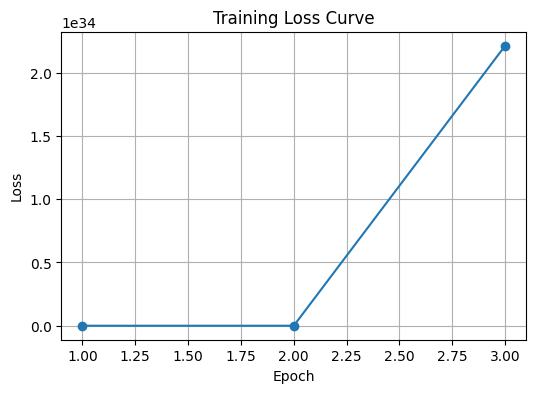

In [202]:
import matplotlib.pyplot as plt

num_epochs = 10
losses = [] # 用来存储每个epoch的losss

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    losses.append(l.item())  # 转成 Python 数字存储
    print(f'epoch{epoch + 1}, loss {l:f}')

# 训练结束后绘制loss曲线
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()